In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

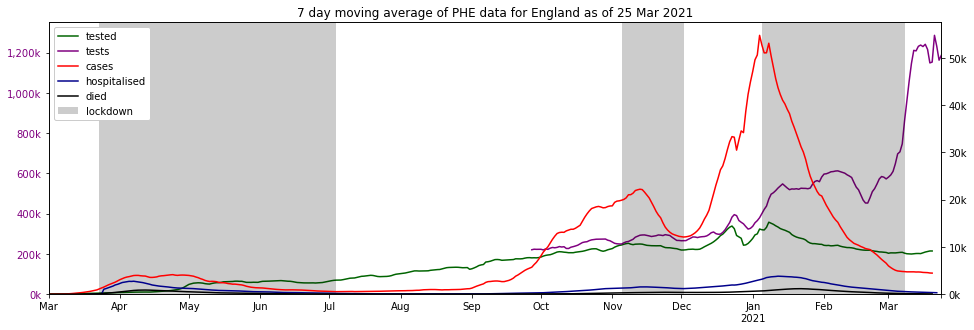

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

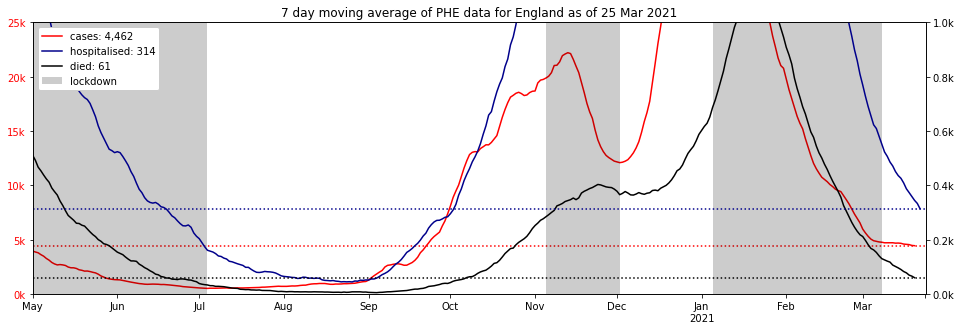

In [3]:
plot_summary(earliest_date='2020-05-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=25_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=1_000)

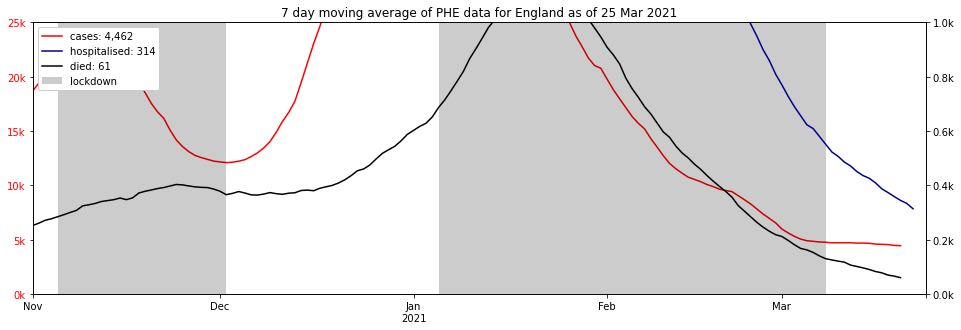

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=25_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter, right_ymax=1_000)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,2028543.0,24681955.0,22653412.0,56286961,3.603931,40.246287,56.149782
1,Northern Ireland,N92000002,104907.0,703334.0,598427.0,1893667,5.539886,31.601491,62.858623
2,Scotland,S92000003,263236.0,2285711.0,2022475.0,5463300,4.818260,37.019292,58.162448
3,Wales,W92000004,378795.0,1320188.0,941393.0,3152879,12.014257,29.858203,58.127540


'partial: 28,991,188 (43.4%), full: 2,775,481'

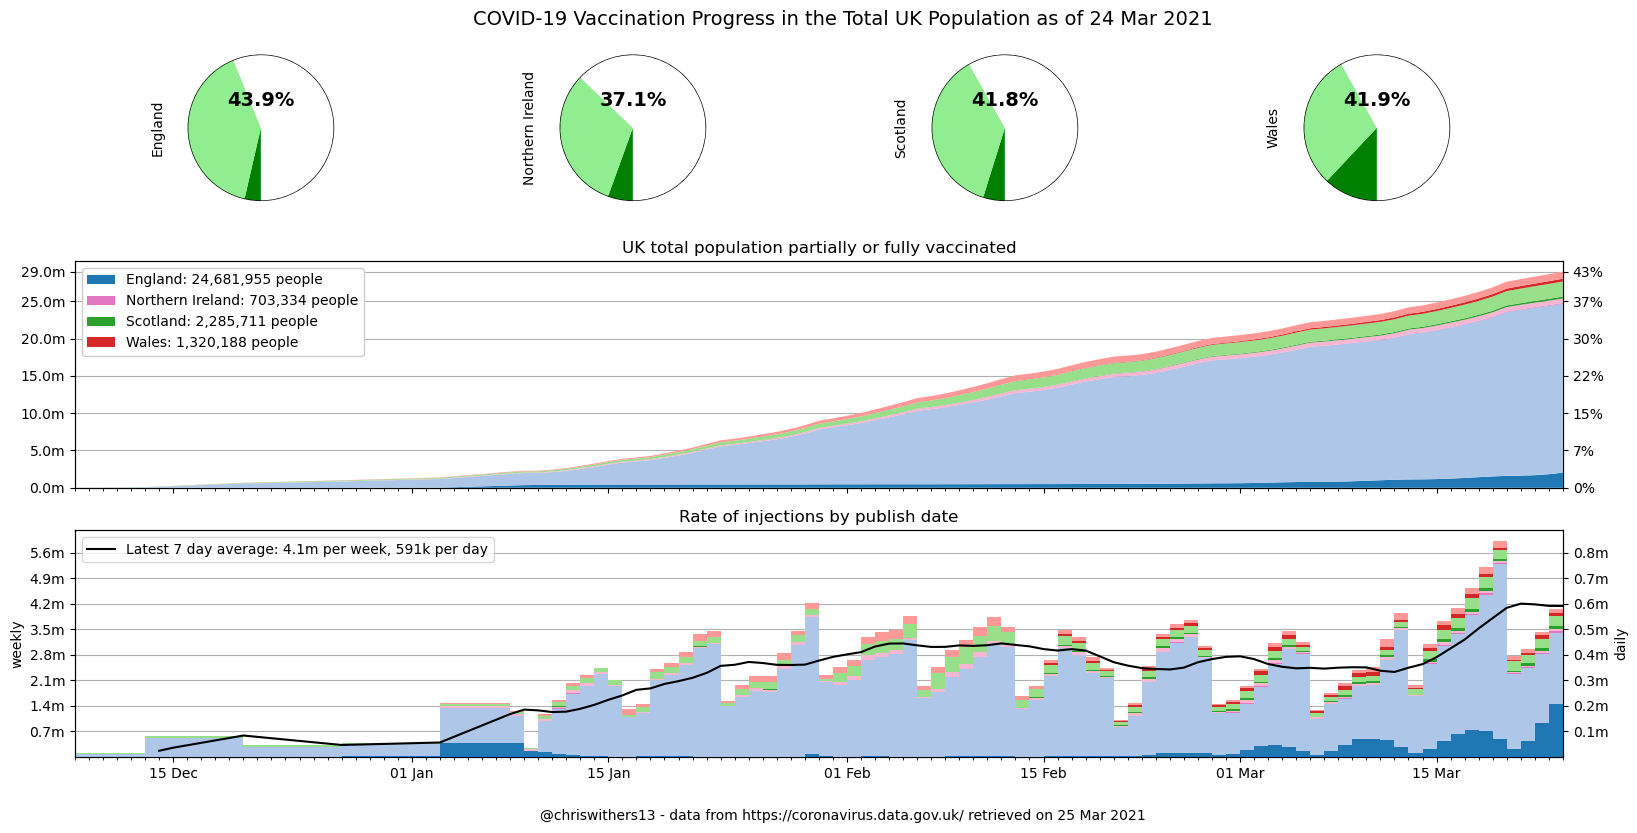

In [5]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [6]:
vaccination_changes()

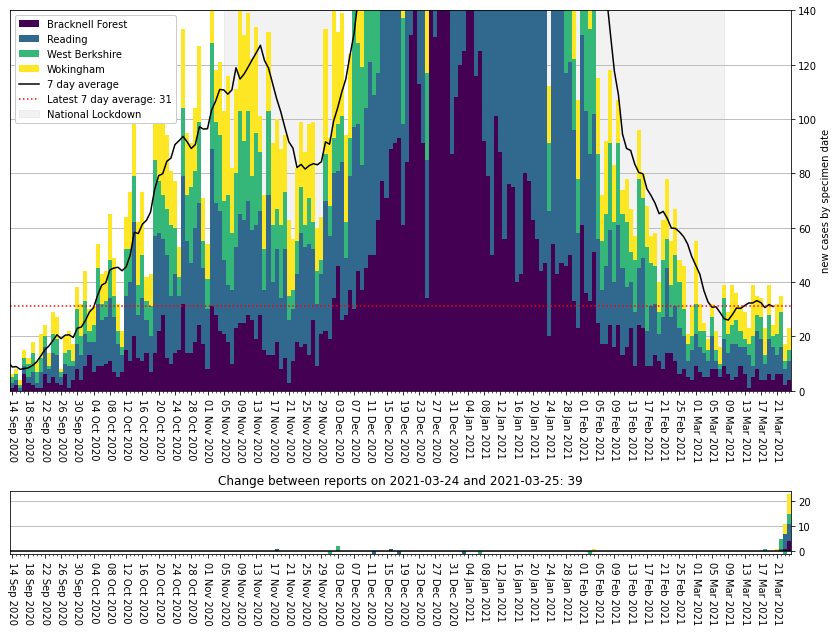

In [7]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=140)

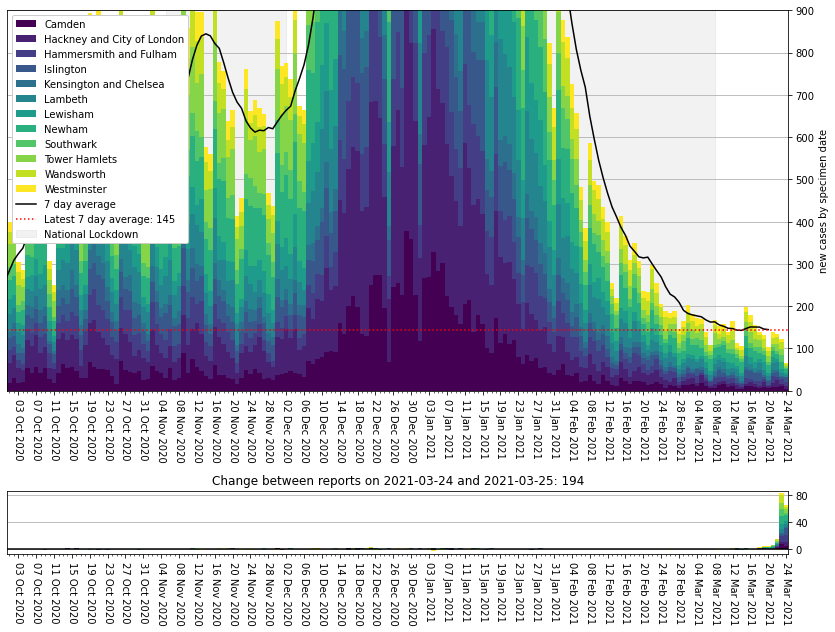

In [8]:
plot_areas(for_date, areas=london_areas, ylim=900)

In [9]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [10]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,202.165665,146.0,2021-03-24
S12000040,West Lothian,152.921901,280.0,2021-03-24
E08000018,Rotherham,148.825783,395.0,2021-03-24
E06000013,North Lincolnshire,145.102500,250.0,2021-03-24
E08000016,Barnsley,140.967164,348.0,2021-03-24
E07000218,North Warwickshire,134.836970,88.0,2021-03-24
E06000010,"Kingston upon Hull, City of",130.111095,338.0,2021-03-24
E08000032,Bradford,130.053948,702.0,2021-03-24
E08000017,Doncaster,126.647215,395.0,2021-03-24


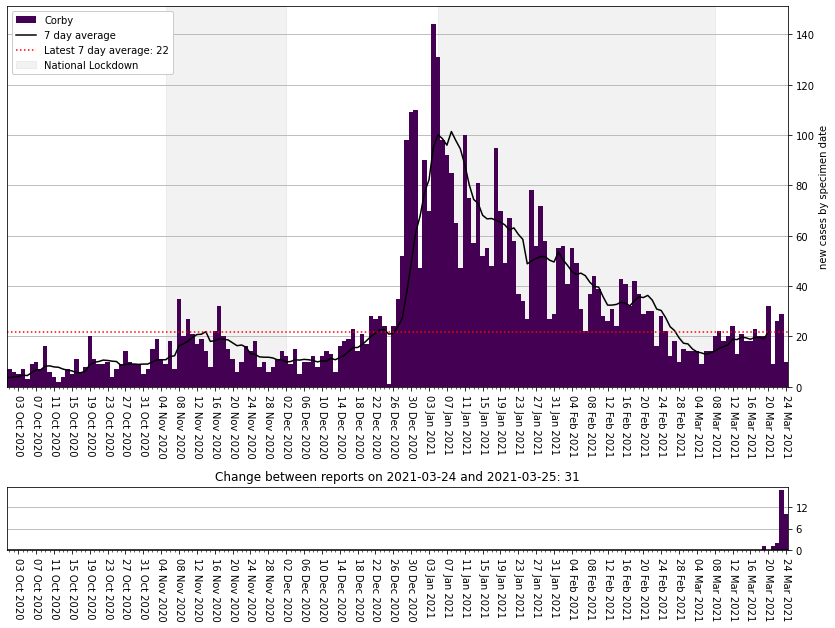

In [11]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [12]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,94.056653,746.0,2021-03-24
E08000025,Birmingham,62.619546,715.0,2021-03-24
E08000032,Bradford,130.053948,702.0,2021-03-24
E08000019,Sheffield,111.651988,653.0,2021-03-24
S12000049,Glasgow City,95.558504,605.0,2021-03-24
E08000036,Wakefield,122.878339,428.0,2021-03-24
E08000003,Manchester,77.235022,427.0,2021-03-24
E06000047,County Durham,79.608522,422.0,2021-03-24
S12000050,North Lanarkshire,123.033658,420.0,2021-03-24


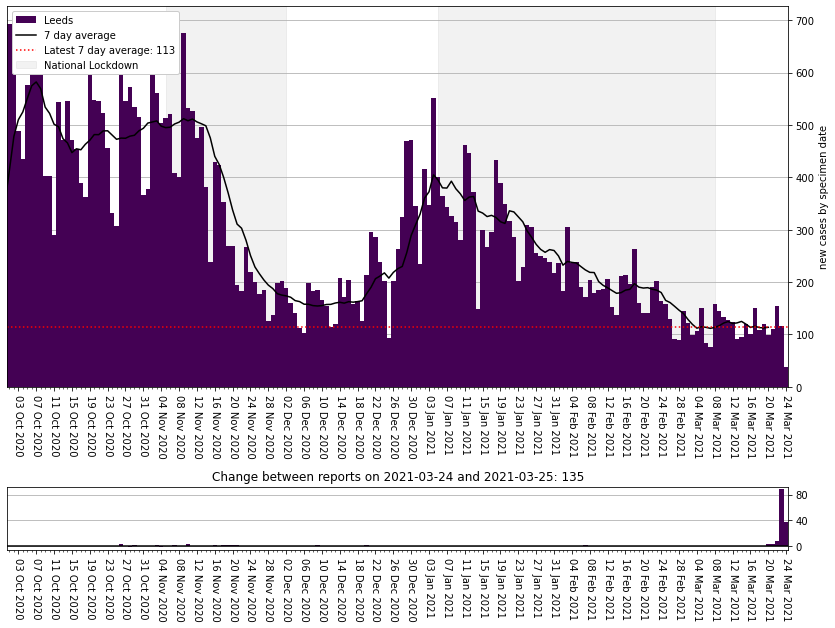

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [14]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.2

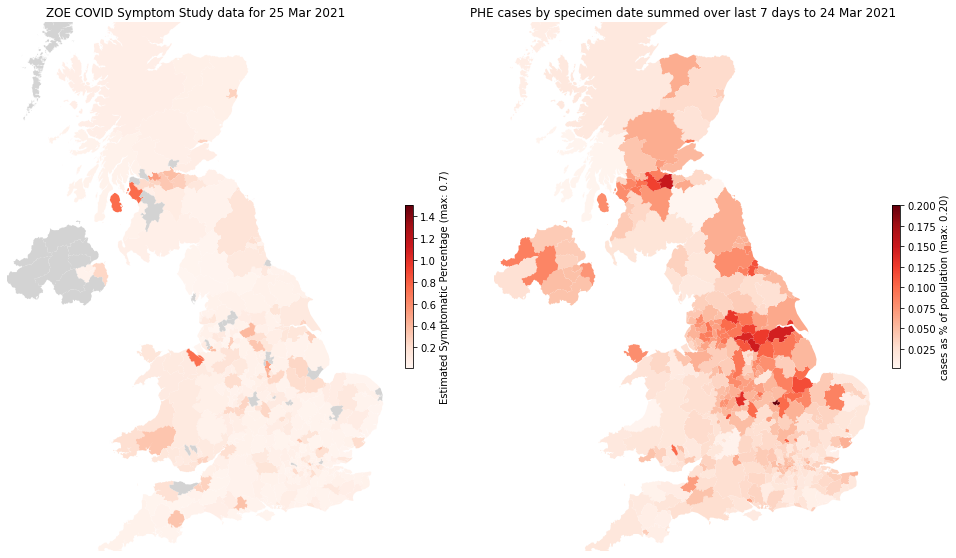

In [15]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [16]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

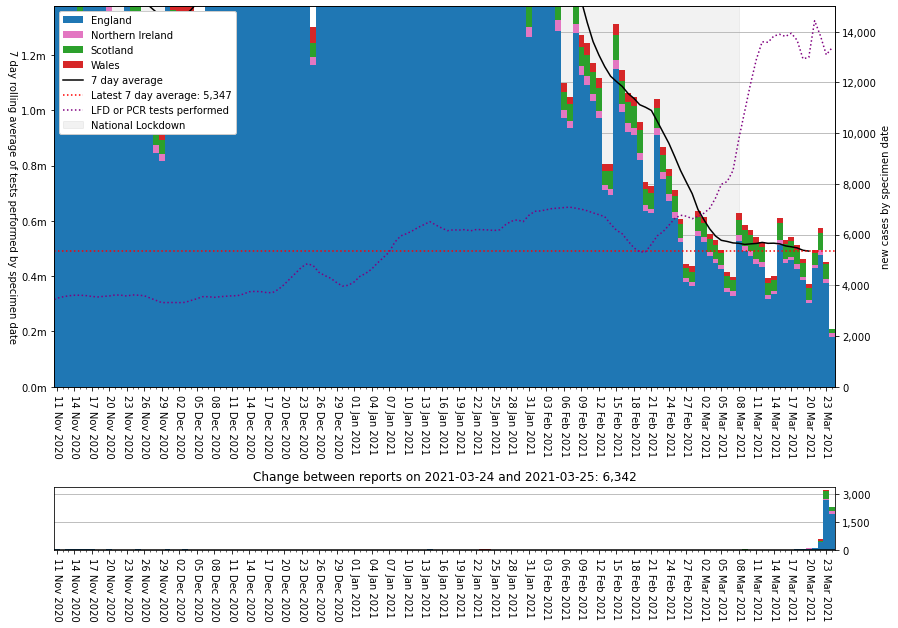

In [17]:
plot_areas(for_date, 'cases_nations', ylim=15_000, earliest='2020-11-11')